In [1]:
#### check which version of python is used in Jupyter
import sys
print(sys.executable)
print(sys.version)

/Users/riyanandi/Desktop/ML/Apziva2/project2/bin/python3.11
3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.1.0.2.5)]


### 1. IMPORT TERM DEPOSIT DATA ###

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

data=pd.read_csv('term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


### 2. Pycaret library to automate model prediction ###

Pycaret is a low-code library on to compare the performance of different ML models 



In [94]:
from pycaret.classification import setup, compare_models
# Initialize the PyCaret environment

clf = setup(data=data, 
            target='y', 
            session_id=123, 
            fix_imbalance=True, 
            normalize=True, 
            feature_selection=True, 
            fold=5,  # Setting 5-fold CV
            fold_strategy='kfold',  # Using simple k-fold
            fold_shuffle=True,  # Shuffle data before splitting into folds
            remove_multicollinearity=True
           )

,Description,Value
0,Session id,123
1,Target,y
2,Target type,Binary
3,Target mapping,"no: 0, yes: 1"
4,Original data shape,"(40000, 14)"
5,Transformed data shape,"(63946, 3)"
6,Transformed train set shape,"(51946, 3)"
7,Transformed test set shape,"(12000, 3)"
8,Numeric features,5
9,Categorical features,8


In [95]:
# Compare all models and select the best one
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9276,0.5000,0.9276,0.8605,0.8928,0.0000,0.0000,0.8960
nb,Naive Bayes,0.8923,0.8457,0.8923,0.9266,0.9057,0.4099,0.4311,0.7540
qda,Quadratic Discriminant Analysis,0.8919,0.8449,0.8919,0.9264,0.9054,0.4085,0.4297,0.8200
et,Extra Trees Classifier,0.8885,0.8043,0.8885,0.9140,0.8989,0.3348,0.3464,1.2520
lightgbm,Light Gradient Boosting Machine,0.8874,0.8734,0.8874,0.9241,0.9005,0.3835,0.4068,2.0940
ridge,Ridge Classifier,0.8818,0.8679,0.8818,0.9267,0.8989,0.3940,0.4231,0.8420
lda,Linear Discriminant Analysis,0.8818,0.8679,0.8818,0.9267,0.8989,0.3940,0.4231,0.9040
rf,Random Forest Classifier,0.8789,0.8287,0.8789,0.9120,0.8923,0.3139,0.3285,1.4220
xgboost,Extreme Gradient Boosting,0.8771,0.8637,0.8771,0.9218,0.8940,0.3655,0.3893,1.0840
dt,Decision Tree Classifier,0.8725,0.6655,0.8725,0.9052,0.8856,0.2680,0.2797,0.7720


**LighGBM is chosen for it's high F1 score and AUC**

In [96]:
from pycaret.classification import create_model,tune_model,evaluate_model

# Create and train the best model
model = create_model('lightgbm')

# Tune the model's hyperparameters
tuned_model = tune_model(model)

# Evaluate the model
evaluate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9230,0.8786,0.9230,0.9249,0.9239,0.4297,0.4299
1,0.9236,0.8652,0.9236,0.9218,0.9227,0.4144,0.4146
2,0.8257,0.8771,0.8257,0.9278,0.8624,0.3017,0.3644
3,0.9255,0.8786,0.9255,0.9217,0.9235,0.4446,0.4455
4,0.8391,0.8677,0.8391,0.9241,0.8699,0.3274,0.3798
Mean,0.8874,0.8734,0.8874,0.9241,0.9005,0.3835,0.4068
Std,0.0451,0.0058,0.0451,0.0023,0.0281,0.0577,0.0304


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9288,0.8723,0.9288,0.9208,0.9241,0.3903,0.3947
1,0.9254,0.8596,0.9254,0.9164,0.9201,0.3640,0.3688
2,0.8388,0.8768,0.8388,0.9297,0.8715,0.3252,0.3847
3,0.9304,0.8755,0.9304,0.9197,0.9230,0.4077,0.4200
4,0.8420,0.8700,0.8420,0.9258,0.8721,0.3376,0.3912
Mean,0.8930,0.8708,0.8930,0.9225,0.9022,0.3650,0.3919
Std,0.0431,0.0061,0.0431,0.0047,0.0248,0.0310,0.0166


Fitting 5 folds for each of 10 candidates, totalling 50 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### 3. Data Processing ###

In [3]:
#separate different columns
binary_cols=['default','housing','loan','y']
onehot_cols=['contact','job','marital','month']
ordinal_cols=['education']

#### 3.1 Transform Binary Categorical Columns ####

In [4]:
# different categories have to be transformed differently
#binary transform

# Define map values
mapping = {'yes': 1,
           'no': 0}

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data
    
# Call function
binarised_df = binarise_values(data, binary_cols, mapping)
binarised_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


#### 3.2 Transform other categorical columns using One-hot encoding and Ordinal encoding ####

In [5]:
#onehot and ordinal transform
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

education_rank = [['unknown', 'primary', 'secondary','tertiary']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

#Define onehot encoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [6]:
numerical_cols_df=binarised_df.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Encode ordinals and create dfs
ord_encoded = ord_encoder.fit_transform(binarised_df[ordinal_cols])
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = ordinal_cols

# One-hot encoding
one_hot_encoded = ohe_encoder.fit_transform(binarised_df[onehot_cols])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = ohe_encoder.get_feature_names_out()

# Reset the index for all DataFrames to ensure alignment
numerical_cols_df = numerical_cols_df.reset_index(drop=True)
ord_encoded_df = ord_encoded_df.reset_index(drop=True)
one_hot_encoded_df = one_hot_encoded_df.reset_index(drop=True)

# Join encoded dfs to a single df and show head
df_encoded = pd.concat([numerical_cols_df,ord_encoded_df,one_hot_encoded_df], axis=1)
df_encoded.head()

,age,default,balance,housing,loan,day,duration,campaign,y,education,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,261,1,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,44,0,29,1,0,5,151,1,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,33,0,2,1,1,5,76,1,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,47,0,1506,1,0,5,92,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,33,0,1,0,0,5,198,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 4. Split the data into training and testing sets ###

In [7]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Assign attribute and output variable
X=df_encoded.drop(['y'],axis=1)
y=df_encoded['y']

seed=123

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

training_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
print("training data size:",X_train.shape,y_train.shape)
print("test data size:",X_test.shape,y_test.shape)

training data size: (30000, 38) (30000,)
test data size: (10000, 38) (10000,)


### 5. Data Imbalances ###

#### 5.1 Random Undersampling ####

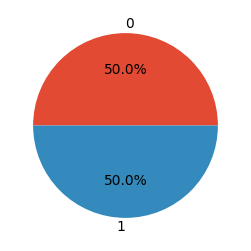

y
0    2208
1    2208
Name: count, dtype: int64


In [8]:
### random undersampling ###
plt.figure(figsize=(4,3))

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1)  # float

# Perform the resampling
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

# Plot the value counts of the resampled target variable as a pie chart
y_train_rus.value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')  # To remove the y-label
plt.show()
print(y_train_rus.value_counts())

# New undersampled dataset
training_df_US = pd.DataFrame(X_train_rus, columns=X_train.columns)
training_df_US['y'] = y_train_rus

#### 5.2 random oversampling ####

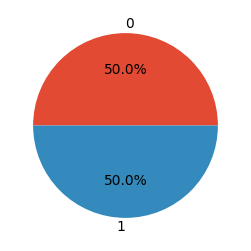

y
0    27792
1    27792
Name: count, dtype: int64


In [9]:

plt.figure(figsize=(4,3))

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy=1)  # float

# Perform the resampling
X_train_ros, y_train_ros = ros.fit_resample(X_train,y_train)

# Plot the value counts of the resampled target variable as a pie chart
y_train_ros.value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')  # To remove the y-label
plt.show()
print(y_train_ros.value_counts())

# New undersampled dataset
training_df_OS = pd.DataFrame(X_train_ros, columns=X_train.columns)
training_df_OS['y'] = y_train_ros

#### 5.3 SMOTE-ENN ####

Resampled dataset saved successfully.


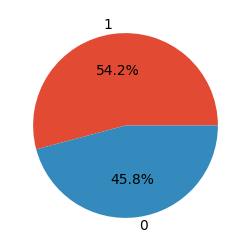

y
1    24365
0    20625
Name: count, dtype: int64


In [10]:
from imblearn.combine import SMOTEENN
from sklearn.datasets import make_classification

plt.figure(figsize=(4,3))

# Apply SMOTEENN
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=seed)
X_train_SmoteENN, y_train_SmoteENN = smote_enn.fit_resample(X_train,y_train)

# Combine the resampled features and target into a single DataFrame
feature_names=X_train.columns.to_list()
training_df_SmoteENN = pd.DataFrame(X_train_SmoteENN, columns=feature_names)
training_df_SmoteENN['y'] = y_train_SmoteENN


print("Resampled dataset saved successfully.")
# Plot the value counts of the resampled target variable as a pie chart
training_df_SmoteENN['y'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')  # To remove the y-label
plt.show()
print(training_df_SmoteENN['y'].value_counts())

#### 5.4 SMOTE - Tomek links ####

Resampled dataset saved successfully.


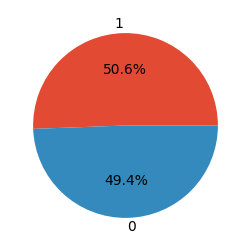

y
1    27792
0    27151
Name: count, dtype: int64


In [11]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

plt.figure(figsize=(4,3))

# Apply SMOTETomek
smote_tomek=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train_smtomek, y_train_smtomek = smote_tomek.fit_resample(X_train,y_train)

# Combine the resampled features and target into a single DataFrame
feature_names=X_train.columns.to_list()
training_df_smtomek = pd.DataFrame(X_train_smtomek, columns=feature_names)
training_df_smtomek['y'] = y_train_smtomek


print("Resampled dataset saved successfully.")
# Plot the value counts of the resampled target variable as a pie chart
training_df_smtomek['y'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')  # To remove the y-label
plt.show()
print(training_df_smtomek['y'].value_counts())

### 6. Model Building ###

In [12]:
# choose which resampled dataset to use 
training_df_resampled=training_df_SmoteENN.copy()
X_train_resampled=training_df_resampled.drop(['y'],axis=1)
y_train_resampled=training_df_resampled['y']
print(y_train_resampled.value_counts())

y
1    24365
0    20625
Name: count, dtype: int64


#### 6.1 Optuna- hyperparameter optimization framework ####

In [139]:
#Optuna
import optuna
import lightgbm as lgbm
from sklearn.metrics import f1_score
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'verbose': -1,
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'n_estimators': trial.suggest_int('n_estimators', 1, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'num_leaves': 31,
        'force_col_wise': 'true',
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 100.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 100.0),
        'random_state':seed
    }
    
    # Create a LightGBM dataset
    dtrain = lgbm.Dataset(X_train_resampled, label=y_train_resampled)

    # Train the model
    model = lgbm.train(param, dtrain)

    # Make predictions on the validation set
    y_pred = model.predict(X_test)
    y_pred_labels = (y_pred > 0.5).astype(int)  # Assuming a binary classification task

    # Calculate F1 score for class 1
    f1_class_1 = f1_score(y_test, y_pred_labels, pos_label=1)

    # Return the F1 score as the objective value to be maximized
    return f1_class_1

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')  # maximize f1 
study.optimize(objective, n_trials=200)

[I 2024-08-28 23:24:54,468] A new study created in memory with name: no-name-b3a1f14d-5090-499a-a49e-f8f69baffdcd
[I 2024-08-28 23:24:54,790] Trial 0 finished with value: 0.4940530649588289 and parameters: {'n_estimators': 140, 'learning_rate': 0.1351967952868513, 'max_depth': 11, 'subsample': 0.13771706517155566, 'colsample_bytree': 0.9006788919901632, 'min_child_weight': 7, 'reg_alpha': 75.94964720178893, 'reg_lambda': 77.25004046701376}. Best is trial 0 with value: 0.4940530649588289.
[I 2024-08-28 23:24:54,960] Trial 1 finished with value: 0.4905829596412556 and parameters: {'n_estimators': 179, 'learning_rate': 0.31845014480117617, 'max_depth': 20, 'subsample': 0.8691947685842479, 'colsample_bytree': 0.8587173525315522, 'min_child_weight': 15, 'reg_alpha': 95.25078283718827, 'reg_lambda': 63.07696362884337}. Best is trial 0 with value: 0.4940530649588289.
[I 2024-08-28 23:24:55,141] Trial 2 finished with value: 0.5039761431411531 and parameters: {'n_estimators': 83, 'learning_rate

Best parameters for the lightGBM model:

[I 2024-08-27 09:15:30,490] Trial 155 finished with value: 0.7575945971306831 and parameters: {'n_estimators': 290, 'learning_rate': 0.20281250459069808, 'max_depth': 15, 'subsample': 0.2420735443713712, 'colsample_bytree': 0.9995360070274627, 'min_child_weight': 14, 'reg_alpha': 0.062156472727208874, 'reg_lambda': 67.68037984153727}. Best is trial 155 with value: 0.7575945971306831.

#### 6.2 Feature Permutation Importance ####

Train a base model

In [14]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import lightgbm as lgbm


# Train a LightGBM model
# Specify all model parameters inside the LGBMClassifier
model = lgbm.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    n_estimators=290,       # Number of boosting rounds
    learning_rate=0.2,      # Step size shrinkage
    max_depth=15,           # Maximum depth of the tree
    subsample=0.24,          # Fraction of samples used for training each tree
    colsample_bytree=1,   # Fraction of features used for each tree
    min_child_weight=14,     # Minimum sum of instance weight (hessian) needed in a child
    reg_alpha=0.06,          # L1 regularization term on weights
    reg_lambda=67.7,         # L2 regularization term on weights
    random_state=seed,        # Random seed for reproducibility
    verbose=-1              # Suppress warnings
)

model.fit(X_train_resampled, y_train_resampled)

y_pred=model.predict(X_test)
# Calculate F1 score with macro averaging on the test set
f1_macro = f1_score(y_test, model.predict(X_test), average='macro')
print(f"F1 Score (Macro Average): {f1_macro:.4f}")

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

F1 Score (Macro Average): 0.7476
Accuracy: 0.9147
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      9312
           1       0.43      0.73      0.54       688

    accuracy                           0.91     10000
   macro avg       0.70      0.83      0.75     10000
weighted avg       0.94      0.91      0.92     10000



Apply Permutation Feature Importance

In [15]:
from sklearn.metrics import make_scorer

# Define a scorer using make_scorer for f1_macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Compute permutation feature importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=seed, scoring=f1_macro_scorer)

# Display the results
feature_names = X_train_resampled.columns
sorted_idx = perm_importance.importances_mean.argsort()

print("Permutation Feature Importance:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")


Permutation Feature Importance:
contact_telephone: -0.0013 ± 0.0005
marital_divorced: -0.0012 ± 0.0007
job_management: -0.0011 ± 0.0011
marital_single: -0.0010 ± 0.0012
marital_married: -0.0006 ± 0.0016
job_retired: -0.0006 ± 0.0003
age: -0.0001 ± 0.0018
job_technician: -0.0001 ± 0.0011
job_housemaid: -0.0000 ± 0.0001
job_student: -0.0000 ± 0.0002
default: 0.0000 ± 0.0000
month_dec: 0.0000 ± 0.0000
job_unknown: 0.0000 ± 0.0000
loan: 0.0001 ± 0.0011
education: 0.0001 ± 0.0019
job_self-employed: 0.0001 ± 0.0002
job_unemployed: 0.0003 ± 0.0002
job_entrepreneur: 0.0005 ± 0.0003
job_admin: 0.0008 ± 0.0009
month_oct: 0.0009 ± 0.0001
balance: 0.0010 ± 0.0024
campaign: 0.0018 ± 0.0015
job_blue-collar: 0.0021 ± 0.0015
job_services: 0.0030 ± 0.0008
month_jan: 0.0032 ± 0.0010
month_jun: 0.0039 ± 0.0012
month_mar: 0.0049 ± 0.0003
month_nov: 0.0064 ± 0.0011
contact_cellular: 0.0083 ± 0.0021
housing: 0.0117 ± 0.0022
month_apr: 0.0118 ± 0.0012
month_may: 0.0134 ± 0.0019
month_feb: 0.0134 ± 0.0011
mon

Features with mean very close to zero, and correspondingly small standerd deviations are not important to model performance, so we drop those columns

In [16]:
cols_to_drop = [feature_names[i] for i in range(len(feature_names)) if abs(perm_importance.importances_mean[i]) < 0.001]
#print(cols_to_drop)

# Now drop those columns
training_df_mod = training_df_resampled.drop(columns=cols_to_drop)
test_df_mod =test_df.drop(columns=cols_to_drop)

X_train_mod = training_df_mod.drop(['y'],axis=1)
y_train_mod = training_df_mod['y']
X_test_mod = test_df_mod.drop(['y'],axis=1)
y_test_mod = test_df_mod['y']

training_df_mod.head()

,balance,housing,day,duration,campaign,contact_cellular,contact_telephone,contact_unknown,job_blue-collar,job_management,...,month_apr,month_aug,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,y
0,892,1,21,316,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,64,0,7,219,1,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,268,1,8,226,5,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,118,1,9,296,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0,1,11,117,2,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


We find a new set of parameters for the modified dataset, and use k-fold cross validation to find the best model

In [143]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'verbose': -1,
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'n_estimators': trial.suggest_int('n_estimators', 1, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 100.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 100.0),
        'random_state':seed
    }
    
    # Train the model
    model = lgbm.LGBMClassifier(**param)

    # Use cross-validation for evaluation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    f1_macro_scorer = make_scorer(f1_score, average='macro')
    
    # Compute the cross-validated F1 macro score
    cv_score = cross_val_score(model, X_train_mod, y_train_mod, cv=skf, scoring=f1_macro_scorer).mean()

    # Optuna tries to maximize the objective function value by default
    return cv_score

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')  # maximize f1 
study.optimize(objective, n_trials=100)

[I 2024-08-28 23:29:54,853] A new study created in memory with name: no-name-3629adb6-e38d-4d1c-8ecb-26d777313796
[I 2024-08-28 23:29:56,609] Trial 0 finished with value: 0.968547769701356 and parameters: {'n_estimators': 271, 'learning_rate': 0.014764675661677572, 'max_depth': 13, 'subsample': 0.6162916127993457, 'colsample_bytree': 0.6318117844620904, 'min_child_weight': 19, 'reg_alpha': 60.57950648224515, 'reg_lambda': 8.648883271513519}. Best is trial 0 with value: 0.968547769701356.
[I 2024-08-28 23:29:57,054] Trial 1 finished with value: 0.9676366980817779 and parameters: {'n_estimators': 163, 'learning_rate': 0.5204522338177573, 'max_depth': 4, 'subsample': 0.31776706931849374, 'colsample_bytree': 0.7016823777788511, 'min_child_weight': 6, 'reg_alpha': 97.84332934499528, 'reg_lambda': 1.9953172446925405}. Best is trial 0 with value: 0.968547769701356.
[I 2024-08-28 23:29:58,099] Trial 2 finished with value: 0.9778545755291745 and parameters: {'n_estimators': 289, 'learning_rate'

**[I 2024-08-27 09:40:29,323] Trial 71 finished with value: 0.9818623701322899 and parameters: {'n_estimators': 157, 'learning_rate': 0.8880572038936302, 'max_depth': 19, 'subsample': 0.2177140621850344, 'colsample_bytree': 0.9376183427507219, 'min_child_weight': 6, 'reg_alpha': 0.06357346359614091, 'reg_lambda': 50.5265056608016}. Best is trial 71 with value: 0.9818623701322899.**

#### 6.3 Apply model on test data ####

In [17]:
# Define the best model using the parameters obtained from Optuna optimization
import lightgbm as lgbm

best_model = lgbm.LGBMClassifier(n_estimators=157,learning_rate=0.88,max_depth=19,subsample=0.22,
    colsample_bytree=0.94,min_child_weight=6,reg_alpha=0.06,reg_lambda=50,random_state=seed)

# Fit the model on the training data
best_model.fit(X_train_mod, y_train_mod)

# Make predictions on the test data
y_pred = best_model.predict(X_test_mod)

# Calculate the accuracy
accuracy = accuracy_score(y_test_mod, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_mod, y_pred))

Accuracy: 0.9122
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      9312
           1       0.42      0.72      0.53       688

    accuracy                           0.91     10000
   macro avg       0.70      0.82      0.74     10000
weighted avg       0.94      0.91      0.92     10000



Text(0.5, 1.0, 'Confusion Matrix on Test Data')

<Figure size 400x300 with 0 Axes>

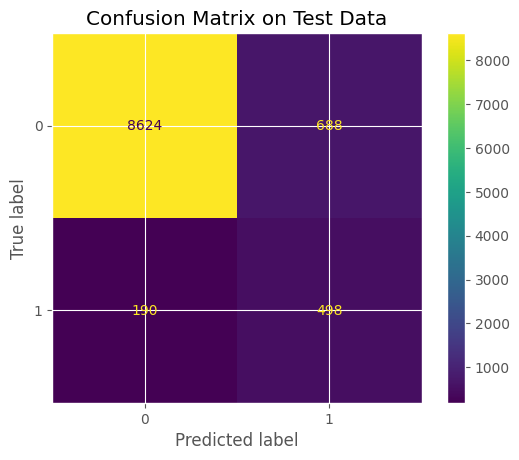

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute the confusion matrix
y_pred=best_model.predict(X_test_mod)
cm = confusion_matrix(y_test_mod, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(4, 3))
disp.plot()
plt.title('Confusion Matrix on Test Data')

**The model performs same as the original, no improvement after feature elimination**

<Figure size 400x1000 with 0 Axes>

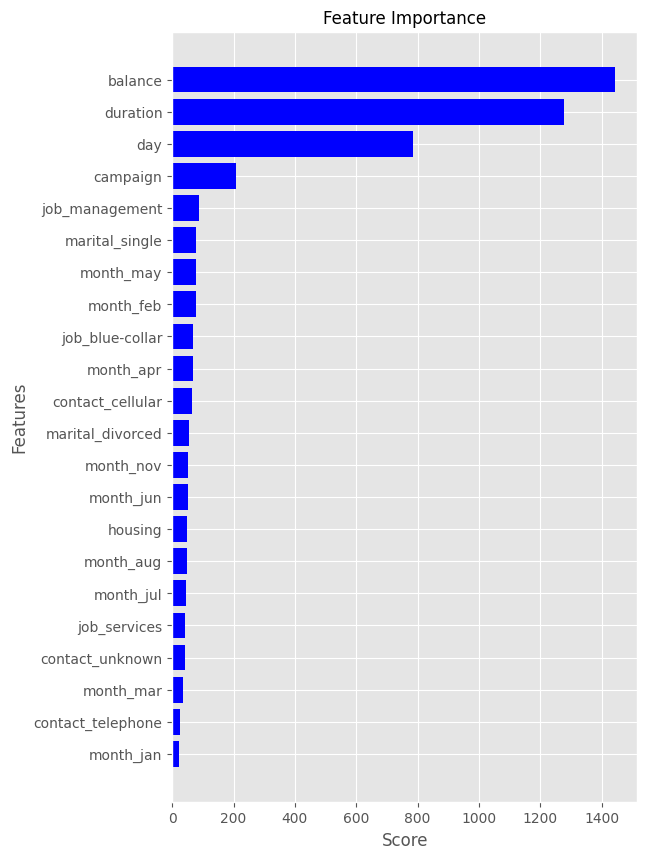

balance: 1443.0000
duration: 1276.0000
day: 784.0000
campaign: 208.0000
job_management: 86.0000
marital_single: 79.0000
month_may: 78.0000
month_feb: 78.0000
job_blue-collar: 68.0000
month_apr: 68.0000
contact_cellular: 66.0000
marital_divorced: 55.0000
month_nov: 53.0000
month_jun: 52.0000
housing: 50.0000
month_aug: 50.0000
month_jul: 45.0000
job_services: 43.0000
contact_unknown: 43.0000
month_mar: 34.0000
contact_telephone: 24.0000
month_jan: 23.0000


In [19]:
# Get feature importances
plt.figure(figsize=(4,10))

# Get feature importances
feature_importances = best_model.feature_importances_
feature_names = X_train_mod.columns

# Create a DataFrame for better handling
importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort features by importance in descending order
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(6, 10))
plt.barh(importances_df['feature'], importances_df['importance'], color='blue')
plt.xlabel('Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# Print sorted feature importances
for name, importance in zip(importances_df['feature'], importances_df['importance']):
    print(f'{name}: {importance:.4f}')

#### 6.4 SHAP is used to increase transparency and interpretability of machine learning models. ####

In [20]:
import shap
# Fits the explainer
explainer = shap.Explainer(best_model.predict, X_test_mod)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_mod)

PermutationExplainer explainer: 10001it [13:27, 12.23it/s]                      


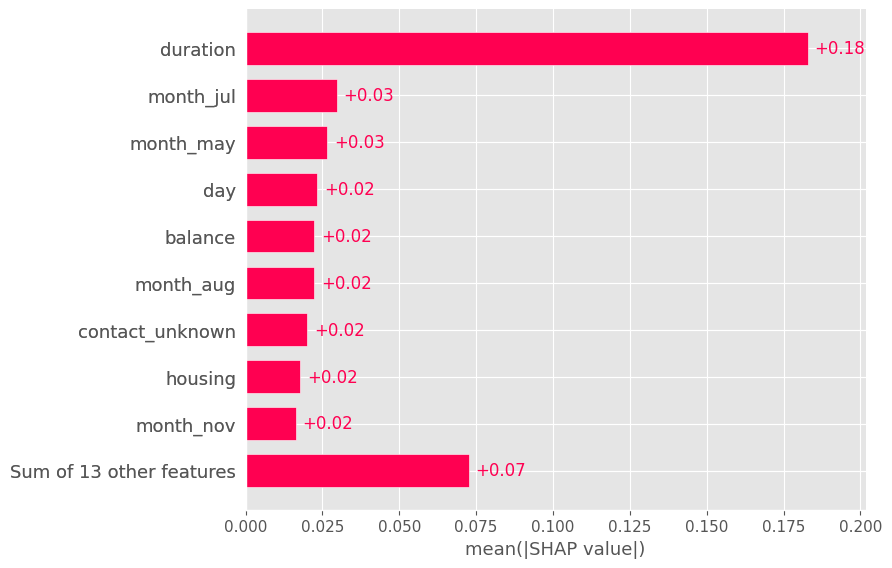

In [22]:
plt.figure(figsize=(4,3))
shap.plots.bar(shap_values)

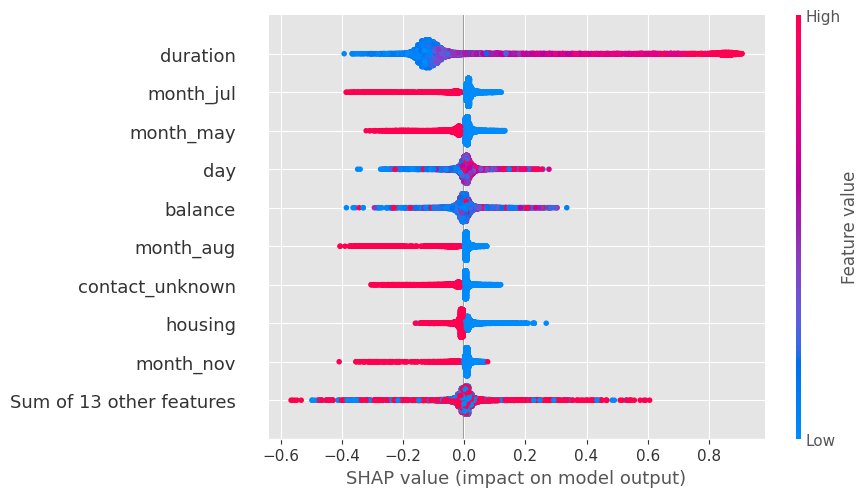

In [23]:
shap.plots.beeswarm(shap_values)

### Try with the most important features ###

In [27]:
cols_to_keep = ['balance','duration','day','month_jul','month_may','housing','contact_unknown','y']
#print(cols_to_drop)

# Now drop those columns
training_df_mod2 = training_df_resampled[cols_to_keep]
test_df_mod2 =test_df[cols_to_keep]

X_train_mod2 = training_df_mod2.drop(['y'],axis=1)
y_train_mod2 = training_df_mod2['y']
X_test_mod2 = test_df_mod2.drop(['y'],axis=1)
y_test_mod2 = test_df_mod2['y']

training_df_mod2.head()

,balance,duration,day,month_jul,month_may,housing,contact_unknown,y
0,892,316,21,0.0,1.0,1,1.0,0
1,64,219,7,0.0,1.0,0,0.0,0
2,268,226,8,0.0,1.0,1,0.0,0
3,118,296,9,1.0,0.0,1,0.0,0
4,0,117,11,1.0,0.0,1,0.0,0


In [30]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'verbose': -1,
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'n_estimators': trial.suggest_int('n_estimators', 1, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 100.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 100.0),
        'random_state':seed
    }
    
    # Train the model
    model = lgbm.LGBMClassifier(**param)

    # Use cross-validation for evaluation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    f1_macro_scorer = make_scorer(f1_score, average='macro')
    
    # Compute the cross-validated F1 macro score
    cv_score = cross_val_score(model, X_train_mod2, y_train_mod2, cv=skf, scoring=f1_macro_scorer).mean()

    # Optuna tries to maximize the objective function value by default
    return cv_score

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')  # maximize f1 
study.optimize(objective, n_trials=100)

[I 2024-09-09 16:15:05,790] A new study created in memory with name: no-name-cb2442b5-250d-46c6-add5-45a0ac55c464
[I 2024-09-09 16:15:06,242] Trial 0 finished with value: 0.9288407592616299 and parameters: {'n_estimators': 160, 'learning_rate': 0.6380789589109002, 'max_depth': 2, 'subsample': 0.5121107335595696, 'colsample_bytree': 0.2945829708735972, 'min_child_weight': 20, 'reg_alpha': 36.69549141946406, 'reg_lambda': 74.56349954165704}. Best is trial 0 with value: 0.9288407592616299.
[I 2024-09-09 16:15:06,667] Trial 1 finished with value: 0.9296002434254479 and parameters: {'n_estimators': 241, 'learning_rate': 0.5196098958903493, 'max_depth': 6, 'subsample': 0.5334541497857406, 'colsample_bytree': 0.9880358655291588, 'min_child_weight': 6, 'reg_alpha': 72.37145895245298, 'reg_lambda': 56.266891569442}. Best is trial 1 with value: 0.9296002434254479.
[I 2024-09-09 16:15:07,204] Trial 2 finished with value: 0.930316138907688 and parameters: {'n_estimators': 104, 'learning_rate': 0.0

Trial 89 finished with value: 0.9595297235417114 and parameters: {'n_estimators': 267, 'learning_rate': 0.8303594393727349, 'max_depth': 6, 'subsample': 0.21300673874956944, 'colsample_bytree': 0.8546776819380086, 'min_child_weight': 12, 'reg_alpha': 3.207620485355565, 'reg_lambda': 36.688674301711224}. Best is trial 89 with value: 0.9595297235417114.

In [31]:
# Define the best model using the parameters obtained from Optuna optimization
import lightgbm as lgbm

best_model = lgbm.LGBMClassifier(n_estimators=267,learning_rate=0.83,max_depth=6,subsample=0.21,
    colsample_bytree=0.85,min_child_weight=12,reg_alpha=3.2,reg_lambda=36.7,random_state=seed)

# Fit the model on the training data
best_model.fit(X_train_mod2, y_train_mod2)

# Make predictions on the test data
y_pred = best_model.predict(X_test_mod2)

# Calculate the accuracy
accuracy = accuracy_score(y_test_mod2, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_mod2, y_pred))

Accuracy: 0.8638
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9312
           1       0.30      0.73      0.42       688

    accuracy                           0.86     10000
   macro avg       0.64      0.80      0.67     10000
weighted avg       0.93      0.86      0.89     10000



### CONCLUSION ###

We achieve an accuracy of 91% with class 1 f1-score of 54% as the best model prediction. We identify call duration and balance as the two most important features of this dataset.